In [1]:
import tensorflow as tf
import os
import zipfile
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

In [2]:
# Ensuring reproducible results
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# https://stackoverflow.com/questions/48631576/reproducible-results-using-keras-with-tensorflow-backend

seed_value = 123

os.environ['PYTHONHASHSEED'] = str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
random.seed(seed_value)

# The below set_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed_value)

# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## 1. Prepare data

### 1.1. Load data 

We will download an archive with some paintings of Manet and Monet, obtained from Wikipedia ([here](https://en.wikipedia.org/wiki/List_of_paintings_by_%C3%89douard_Manet) and [here](https://en.wikipedia.org/wiki/List_of_works_by_Claude_Monet)). 

Pictures were downloaded manually and then saved to an archive.

There are about 100+ Manet's works and 400+ Monet's works.

In [3]:
try:
    shutil.rmtree("/tmp/manet-or-monet_extr")
except:
    pass

In [4]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/manet-or-monet/images.zip" \
    -O "/tmp/manet-or-monet.zip"


--2020-06-04 07:02:33--  https://storage.googleapis.com/manet-or-monet/images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173142583 (165M) [application/x-zip-compressed]
Saving to: ‘/tmp/manet-or-monet.zip’

/tmp/manet-or-monet 100%[===================>] 165.12M  89.4MB/s    in 1.8s    

2020-06-04 07:02:35 (89.4 MB/s) - ‘/tmp/manet-or-monet.zip’ saved [173142583/173142583]



In [5]:
zip_ref = zipfile.ZipFile("/tmp/manet-or-monet.zip", 'r')
zip_ref.extractall("/tmp/manet-or-monet_extr")
zip_ref.close()

In [6]:
print("Pictures of Manet, total: " + str(len(os.listdir('/tmp/manet-or-monet_extr/manet/'))))
print("Pictures of Monet, total: " + str(len(os.listdir('/tmp/manet-or-monet_extr/monet/'))))

Pictures of Manet, total: 109
Pictures of Monet, total: 437


### 1.2. Put data in folders

For each class (artist) we will create folders for train, validation and test and put data there

In [7]:
def create_folder_and_split_for_two_artists(folder_name):
    
    os.mkdir('/tmp/manet-or-monet_extr/' + folder_name)
    os.mkdir('/tmp/manet-or-monet_extr/' + folder_name + '/manet')
    os.mkdir('/tmp/manet-or-monet_extr/' + folder_name + '/monet')

    
create_folder_and_split_for_two_artists(folder_name = 'training_and_validation')
create_folder_and_split_for_two_artists(folder_name = 'training')
create_folder_and_split_for_two_artists(folder_name = 'validation')
create_folder_and_split_for_two_artists(folder_name = 'testing')

Test and validation sets' size is 20% of the sample:

In [8]:
manet_train_size = 69
manet_valid_size = 20
manet_test_size = 20

monet_train_size = 276
monet_valid_size = 80
monet_test_size = 80

random_seed = 1

In [9]:
def split_data_in_two_folders_by_size(SOURCE, FOLDER_1, FOLDER_2, SIZE_1, SIZE_2):
    
    '''
    Takes images from SOURCE folder, shuffles them, then moves SIZE_1 images to FOLDER_1 and SIZE_2 images to FOLDER_2
    '''
    
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    length_1 = int(SIZE_1)
    length_2 = int(SIZE_2)
    shuffled_set = random.sample(files, len(files))
    set_1 = shuffled_set[0:length_1]
    set_2 = shuffled_set[-length_2:]

    for filename in set_1:
        this_file = SOURCE + filename
        destination = FOLDER_1 + filename
        shutil.copyfile(this_file, destination)

    for filename in set_2:
        this_file = SOURCE + filename
        destination = FOLDER_2 + filename
        shutil.copyfile(this_file, destination)


def split_data_in_train_validation_test_for_artist(artist_name, size_for_training, size_for_validation, size_for_testing): 
    
    '''
    Using function split_data_in_two_folders_by_size, splits all pictures of particular artist into 
    3 folders: training, validation and testing (according to respective sizes)
    '''
        
    split_data_in_two_folders_by_size(SOURCE = "/tmp/manet-or-monet_extr/" + artist_name + "/", 
                                      FOLDER_1 = "/tmp/manet-or-monet_extr/training_and_validation/" + artist_name + "/", 
                                      FOLDER_2 = "/tmp/manet-or-monet_extr/testing/" + artist_name + "/", 
                                      SIZE_1 = size_for_training + size_for_validation,
                                      SIZE_2 = size_for_testing)

    split_data_in_two_folders_by_size(SOURCE = "/tmp/manet-or-monet_extr/training_and_validation/" + artist_name + "/", 
                                      FOLDER_1 = "/tmp/manet-or-monet_extr/training/" + artist_name + "/", 
                                      FOLDER_2 = "/tmp/manet-or-monet_extr/validation/" + artist_name + "/", 
                                      SIZE_1 = size_for_training,
                                      SIZE_2 = size_for_validation)
    
split_data_in_train_validation_test_for_artist(artist_name = "manet", 
                                               size_for_training = manet_train_size, 
                                               size_for_validation = manet_valid_size, 
                                               size_for_testing = manet_test_size)

split_data_in_train_validation_test_for_artist(artist_name = "monet", 
                                               size_for_training = monet_train_size, 
                                               size_for_validation = monet_valid_size, 
                                               size_for_testing = monet_test_size)

Final samples' sizes:

In [10]:
def print_number_of_files_in_directories(artist_name):
    
    print(artist_name)
    print("Training: " + str(len(os.listdir('/tmp/manet-or-monet_extr/training/' + artist_name))))
    print("Validation: " + str(len(os.listdir('/tmp/manet-or-monet_extr/validation/' + artist_name))))
    print("Testing: " + str(len(os.listdir('/tmp/manet-or-monet_extr/testing/' + artist_name))))

print_number_of_files_in_directories(artist_name = 'manet')    
print_number_of_files_in_directories(artist_name = 'monet')    


manet
Training: 69
Validation: 20
Testing: 20
monet
Training: 276
Validation: 80
Testing: 80


### 1.3. Print some pictures from each class (artist)

In [11]:
def print_pictures_from_both_classes(manet_folder, monet_folder):

    manet_names = os.listdir(manet_folder)
    monet_names = os.listdir(monet_folder)

    %matplotlib inline

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # Parameters for our graph; we'll output images in a 4x4 configuration
    nrows = 4
    ncols = 4

    # Index for iterating over images
    pic_index = 0

    # Set up matplotlib fig, and size it to fit 4x4 pics
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pic_index += 8
    next_manet_pix = [os.path.join(manet_folder, fname) for fname in manet_names[pic_index-8:pic_index]]
    next_monet_pix = [os.path.join(monet_folder, fname) for fname in monet_names[pic_index-8:pic_index]]

    for i, img_path in enumerate(next_manet_pix + next_monet_pix):
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off') # Don't show axes (or gridlines)

      img = mpimg.imread(img_path)
      plt.imshow(img)

    plt.show()

First 8 pictures (2 rows) are Manet's, last 8 pictures (2 rows) are Monet's:

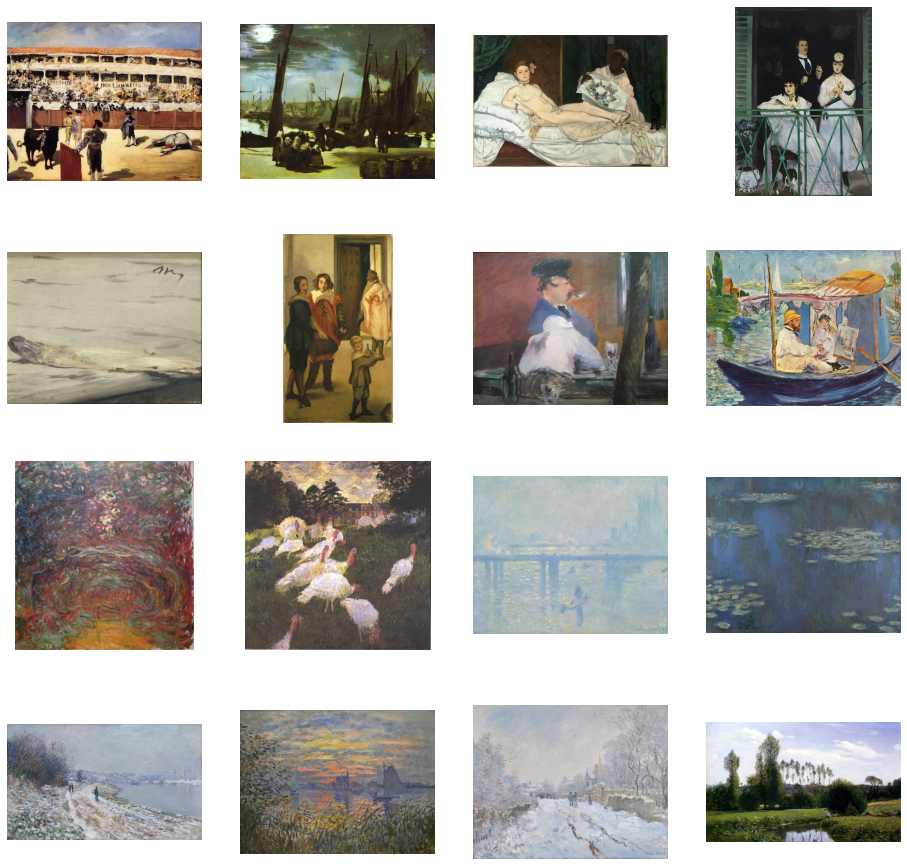

In [12]:
print_pictures_from_both_classes(manet_folder = '/tmp/manet-or-monet_extr/training/manet/',
                                 monet_folder = '/tmp/manet-or-monet_extr/training/monet/')                                

## 2. Modeling

### 2.0. General parameters and variables for all models

In [13]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

# parameters for modeling

input_size = 600
n_epochs = 100
learning_rate = 0.001
loss_function = 'binary_crossentropy'
metrics_list = ['AUC']


# directories

TRAINING_DIR = "/tmp/manet-or-monet_extr/training/"
VALIDATION_DIR = "/tmp/manet-or-monet_extr/validation/"
TESTING_DIR = "/tmp/manet-or-monet_extr/testing/"

train_manet_dir = os.path.join(TRAINING_DIR, 'manet')
train_monet_dir = os.path.join(TRAINING_DIR, 'monet')

validation_manet_dir = os.path.join(VALIDATION_DIR, 'manet')
validation_monet_dir = os.path.join(VALIDATION_DIR, 'monet')

train_manet_fnames = os.listdir(train_manet_dir)
train_monet_fnames = os.listdir(train_monet_dir)

Using TensorFlow backend.


In [14]:
# Data generator for test data

testing_datagen = ImageDataGenerator(rescale=1.0/255.)
testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                            #  batch_size = 30,
                                                              class_mode = 'binary',
                                                              target_size = (input_size, input_size), 
                                                             shuffle = False, 
                                                              seed = 1)

testing_classes = testing_generator.labels
    
testing_values = []

for i in range(testing_generator.__len__() ):
    testing_values.extend(
        testing_generator.__getitem__( i )[0] 
        )

Found 100 images belonging to 2 classes.


In [15]:
# Data generator for validation data

def redefine_validation_generator():
    
    '''
    Redefines generator for proper use of predict method
    for details see: https://stackoverflow.com/questions/61899676/tensorflow-model-evaluate-and-model-predict-very-different-results/61899838
    '''

    validation_datagen = ImageDataGenerator(rescale=1.0/255.)
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                #  batch_size = 30,
                                                                  class_mode = 'binary',
                                                                  target_size = (input_size, input_size), 
                                                                 shuffle = False, 
                                                                  seed = 1)

    validation_classes = validation_generator.labels
    
    validation_values = []

    for i in range(validation_generator.__len__() ):
        validation_values.extend(
            validation_generator.__getitem__( i )[0] 
            )
    
    return validation_generator, validation_classes, validation_values

(validation_generator, validation_classes, validation_values) = redefine_validation_generator()

In [16]:
def plot_accuracy_and_loss_train_and_valid(history, metric):
    
    '''
    Plots metric vs epoch for training and validation based on model fit history
    '''
        
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    train_metric = history.history[metric]
    valid_metric = history.history['val_' + metric]

    epochs = range(len(train_metric)) # Get number of epochs

    plt.plot(epochs, train_metric, 'r')
    plt.plot(epochs, valid_metric, 'b')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(labels = ["Training " + metric, "Validation " + metric])
    plt.title('Training and validation ' + metric)
    plt.figure()


In [17]:
def predict_probs(model, generator):
    
    '''
    Returns probabilities predicted by particular model for generator
    '''
    
    predictions_num = model.predict(generator)
    predictions_num = [i[0]  for i in predictions_num.tolist()]
    # validation_classes = validation_generator.classes.tolist()

    return predictions_num

In [18]:
def calculate_auc_plot_roc(validation_predictions_num, validation_classes):
    
    '''
    Calculates AUC and prints it, plots ROC, returns AUC and dataframe with false positive rate, true positive rate and thresholds
    '''
    
    auc = metrics.roc_auc_score(validation_classes, 
                                             validation_predictions_num)
    
    print("AUC: " + str(auc))

    fpr, tpr, thresholds = metrics.roc_curve(validation_classes, 
                                             validation_predictions_num)
    
    results_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

    plt.plot(fpr, tpr)
    plt.show()
    
    return auc, results_df

In [19]:
def define_threshold_from_tpr(results_df, desired_tpr):
    
    '''
    Takes dataframe with false positive rate, true positive rate and threshold - and desired true positive rate
    Finds threshold value, at which true positive rate is the closest to desired one
    If there are several such cases - takes the one where false positive rate is smaller
    '''
    
    results_df['abs_tpr_desired_tpr_dif'] = abs(results_df['tpr'] - desired_tpr)
    results_df = results_df.sort_values(by = ['abs_tpr_desired_tpr_dif', 'fpr'])
    return results_df.iloc[0,]['thresholds']

In [20]:
def calculate_confusion_matrix(validation_predictions_num, validation_classes, threshold):
    
    '''
    Prints confusion matrix, TPR, TNR for list of numerical predictions, list of actual labels and threshold
    '''
    
    validation_predictions_classes = [int(i > threshold) for i in validation_predictions_num]
    confusion_matrix = tf.math.confusion_matrix(labels = validation_classes, predictions = validation_predictions_classes)
    confusion_matrix = confusion_matrix.numpy()
    print("Threshold: " + str(threshold))
    print("Confusion matrix: ")
    print(confusion_matrix)
    print("True positive rate: " + str(round(confusion_matrix[1,1]/(confusion_matrix[1,1] + confusion_matrix[1,0]), 3)))
    print("True negative rate: " + str(round(confusion_matrix[0,0]/(confusion_matrix[0,0] + confusion_matrix[0,1]), 3)))

In [21]:
def define_misclassified(predictions_num, threshold, real_class, real_values):
    
    '''
    Returns dataframe with actual value (array with picture) and actual label,
    plus boolean column identifying if predicted class (based on threshold) is equal to actual class
    '''
    
    misclassified = pd.DataFrame({'mismatch': [i > threshold for i in predictions_num] != real_class,
    'real_class': real_class,
    'real_value': real_values})
    
    return misclassified
    

In [22]:
def print_misclassified(pd_misclassified, n_pics_to_print):
    
    '''
    Prints misclassified pictures - max n_pics_to_print for each class
    '''
    
    print("False positives (Manet, but classified as Monet):")
    
    for p in pd_misclassified[(pd_misclassified['mismatch'] == True) & (pd_misclassified['real_class'] == 0)]['real_value'].head(n_pics_to_print):
        plt.imshow(p)
        plt.show()
    
    print("False negative (Monet, but classified as Manet):")
    
    for p in pd_misclassified[(pd_misclassified['mismatch'] == True) & (pd_misclassified['real_class'] == 1)]['real_value'].head(n_pics_to_print):
        plt.imshow(p)
        plt.show()

We will also use some custom callback, see description below

In [23]:
class MyEarlyStopping(tf.keras.callbacks.Callback):
    
    '''
    This callback is an edited version of standard EarlyStopping callback in tf:
    https://github.chttps://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/keras/callbacks.py#L1365

    The difference is that it starts counter (defined by patience) once baseline is reached
    So, if baseline is reached, learning will stop in patience steps, and weights will be saved from best epoch during these steps
    If baseline is not reached, learning will continue as long as defined in 'epochs' variable in model.fit 
    (and weights will be saved from best epoch during training)
    '''
    
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline = None,
               restore_best_weights=False):

        super(MyEarlyStopping, self).__init__()

        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1
    
    
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf
        
        self.best_so_far = np.Inf if self.monitor_op == np.less else -np.Inf
    
    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return
        
        if self.wait == 0:
            
            if self.monitor_op(current - self.min_delta, self.best_so_far):
                self.best_so_far = current
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()    
                    if self.verbose > 0:
                        print('\nRestoring model weights from the end of the best (so far) epoch.')
                    self.model.set_weights(self.best_weights)
        
            if self.monitor_op(current - self.min_delta, self.best):
                self.best = current
                self.wait += 1
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()
                    if self.verbose > 0:
                        print('\nRestoring model weights from the end of the best (by baseline) epoch.')
                    self.model.set_weights(self.best_weights)
                    
        else:
        
            if self.monitor_op(current - self.min_delta, self.best_so_far):
                self.best_so_far = current
                if self.restore_best_weights:
                    self.best_weights = self.model.get_weights()    
                    if self.verbose > 0:
                        print('\nRestoring model weights from the end of the best (so far, baseline already reached) epoch.')
                    self.model.set_weights(self.best_weights)
                        
            self.wait += 1
            
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))
        self.model.set_weights(self.best_weights)
    
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            print('Early stopping conditioned on metric `%s` '
                      'which is not available. Available metrics are: %s',
                      self.monitor, ','.join(list(logs.keys())))
    
        return monitor_value

    
auc_train_callback = MyEarlyStopping(monitor = 'AUC', 
                                                patience = 10, 
                                                verbose = 1, 
                                                mode = 'max',
                                                min_delta = 0,
                              baseline = 0.9999,
                                                restore_best_weights = True)

auc_valid_callback = MyEarlyStopping(monitor = 'val_AUC', 
                                                patience = 10, 
                                                verbose = 1, 
                                                mode = 'max',
                                                min_delta = 0,
                              baseline = 0.9,
                                                restore_best_weights = True)

### 2.1. Simple CNN model without image augmentation

We will start with a simple model with 3 convolutional and respective pooling layers

For this model we will not use any data augmentation, and only rescaling is applied

In [25]:
train_datagen_wo_augm = ImageDataGenerator(rescale=1.0/255.)
train_generator_wo_augm = train_datagen_wo_augm.flow_from_directory(TRAINING_DIR,
                                                   # batch_size = 30,
                                                    class_mode='binary',
                                                    target_size=(input_size, input_size))

Found 344 images belonging to 2 classes.


In [30]:
model_simple_cnn_wo_augm = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_simple_cnn_wo_augm.compile(loss = loss_function,
              optimizer = RMSprop(lr = learning_rate),
              metrics = metrics_list)

history_simple_cnn_wo_augm = model_simple_cnn_wo_augm.fit(train_generator_wo_augm,
                              epochs = n_epochs,
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [auc_valid_callback,
                                          tf.keras.callbacks.EarlyStopping(monitor='AUC',  
                                                                           mode='max',
                                                                           min_delta = 0, 
                                                                           patience = 10, 
                                                                           verbose = 1,
                                                                           restore_best_weights=False)])

model_simple_cnn_wo_augm.save('model_simple_cnn_wo_augm')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 3s - loss: 21.9964 - AUC: 0.5658
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 39s 4s/step - loss: 19.8180 - AUC: 0.5765 - val_loss: 0.4053 - val_AUC: 0.8138
Epoch 2/100
10/11 [==========================>...] - ETA: 2s - loss: 0.4489 - AUC: 0.7555
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 36s 3s/step - loss: 0.4588 - AUC: 0.7567 - val_loss: 0.5327 - val_AUC: 0.8506
Epoch 3/100
11/11 [==============================] - 37s 3s/step - loss: 0.4707 - AUC: 0.7845 - val_loss: 0.3131 - val_AUC: 0.8388
Epoch 4/100
11/11 [==============================] - 35s 3s/step - loss: 0.1938 - AUC: 0.9623 - val_loss: 0.9165 - val_AUC: 0.6781
Epoch 5/100
11/11 [==============================] - 36s 3s/step - loss: 0.6664 - AUC: 0.7716 - v

We can see from history plot, that the model overfits very quickly. 

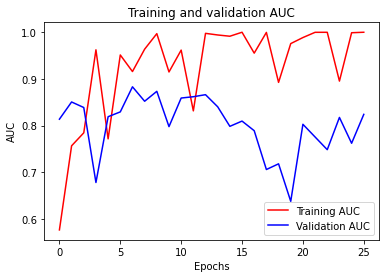

<Figure size 432x288 with 0 Axes>

In [31]:
plot_accuracy_and_loss_train_and_valid(history_simple_cnn_wo_augm, 'AUC')

We can also see overfitting by evaluating model in train and validation set - AUC on training much higher than on validation, and both metrics are comparatively low. 

In [32]:
model_simple_cnn_wo_augm.evaluate(train_generator_wo_augm)
model_simple_cnn_wo_augm.evaluate(validation_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 14s 1s/step - loss: 0.0467 - AUC: 0.9967
  ...
    to  
  ['...']
4/4 [==============================] - 4s 974ms/step - loss: 0.2927 - AUC: 0.8831


[0.2927190503105521, 0.883125]

### 2.2. Simple CNN model with image augmentation

To deal with overfitting we will use image augmentation, with the same model structure. 

In [25]:
train_datagen_with_augm = ImageDataGenerator(rescale=1.0/255.,
                                  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range = [0.5, 1.5],
      channel_shift_range = 100,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator_with_augm = train_datagen_with_augm.flow_from_directory(TRAINING_DIR,
                                                   # batch_size = 30,
                                                    class_mode='binary',
                                                    target_size=(input_size, input_size))

# (validation_generator, validation_classes, validation_values) = redefine_validation_generator()

Found 344 images belonging to 2 classes.


In [34]:
model_simple_cnn_with_augm = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_simple_cnn_with_augm.compile(loss = loss_function,
              optimizer = RMSprop(lr = learning_rate),
              metrics = metrics_list)

history_simple_cnn_with_augm = model_simple_cnn_with_augm.fit(train_generator_with_augm,
                              epochs = n_epochs,
                              verbose = 1,
                              validation_data = validation_generator,
                            callbacks = [auc_valid_callback])

model_simple_cnn_with_augm.save('model_simple_cnn_with_augm')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 5s - loss: 9.1761 - AUC: 0.5193  
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 64s 6s/step - loss: 8.4025 - AUC: 0.5293 - val_loss: 0.3700 - val_AUC: 0.8147
Epoch 2/100
10/11 [==========================>...] - ETA: 5s - loss: 0.4720 - AUC: 0.6679 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 63s 6s/step - loss: 0.4774 - AUC: 0.6646 - val_loss: 0.3646 - val_AUC: 0.8388
Epoch 3/100
11/11 [==============================] - 62s 6s/step - loss: 0.4909 - AUC: 0.6432 - val_loss: 0.3664 - val_AUC: 0.8231
Epoch 4/100
11/11 [==============================] - 62s 6s/step - loss: 0.5737 - AUC: 0.6105 - val_loss: 0.3688 - val_AUC: 0.8038
Epoch 5/100
11/11 [==============================] - 63s 6s/step - loss: 0.5168 - AUC: 0.6406 - 

From the training process chart below we can see, that image augmentation helped to overcome overfitting, as training and validation valies are very close:

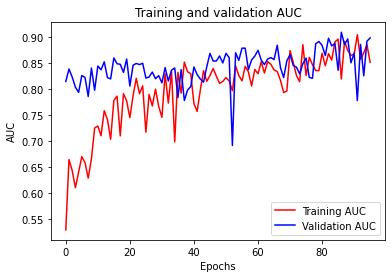

<Figure size 432x288 with 0 Axes>

In [35]:
plot_accuracy_and_loss_train_and_valid(history_simple_cnn_with_augm, 'AUC')

We have saved best results, and now the evaluation shows quite good level of AUC for train and validation:

In [36]:
model_simple_cnn_with_augm.evaluate(train_generator_with_augm)
model_simple_cnn_with_augm.evaluate(validation_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 50s 5s/step - loss: 0.2764 - AUC: 0.9191
  ...
    to  
  ['...']
4/4 [==============================] - 4s 948ms/step - loss: 0.2692 - AUC: 0.9094


[0.26915215607732534, 0.909375]

### 2.3. Simple CNN with augmentation and weights

The data we have is imbalanced, because Monet created much more paintings than Manet. 

With data augmentation we saw quite good results for AUC, but let's also try weighting the data, so that to balance the sample. 

We will use weighting approach from Keras manual: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [41]:
weight_for_manet = (1 / manet_test_size)*(manet_test_size + monet_test_size)/2.0 
weight_for_monet = (1 / monet_test_size)*(manet_test_size + monet_test_size)/2.0

class_weight = {0: weight_for_manet, 1: weight_for_monet}

print('Weight for manet (0): {:.2f}'.format(weight_for_manet))
print('Weight for monet (1): {:.2f}'.format(weight_for_monet))

class_weight = {1: weight_for_monet, 0: weight_for_manet}

Weight for manet (0): 2.50
Weight for monet (1): 0.62


The model itself is the same, with image augmentation

In [42]:
model_simple_cnn_with_augm_and_weights = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# model_simple_cnn_with_augm_and_weights.summary()

model_simple_cnn_with_augm_and_weights.compile(loss = loss_function,
              optimizer = RMSprop(lr = learning_rate),
              metrics = metrics_list)

history_simple_cnn_with_augm_and_weights = model_simple_cnn_with_augm_and_weights.fit(train_generator_with_augm,
                              epochs = n_epochs,
                              verbose = 1,
                            class_weight = class_weight,
                              validation_data = validation_generator,
                              callbacks = [auc_valid_callback])

model_simple_cnn_with_augm.save('model_simple_cnn_with_augm_and_weights')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 5s - loss: 54.5253 - AUC: 0.4663 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 71s 6s/step - loss: 49.6907 - AUC: 0.4812 - val_loss: 0.5419 - val_AUC: 0.7753
Epoch 2/100
11/11 [==============================] - 64s 6s/step - loss: 0.9061 - AUC: 0.5386 - val_loss: 0.7738 - val_AUC: 0.4837
Epoch 3/100
10/11 [==========================>...] - ETA: 5s - loss: 0.6812 - AUC: 0.5975 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 63s 6s/step - loss: 0.6689 - AUC: 0.6192 - val_loss: 0.5382 - val_AUC: 0.8081
Epoch 4/100
10/11 [==========================>...] - ETA: 5s - loss: 0.6365 - AUC: 0.7344 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 62s 6s/step - loss: 0.6349 - 

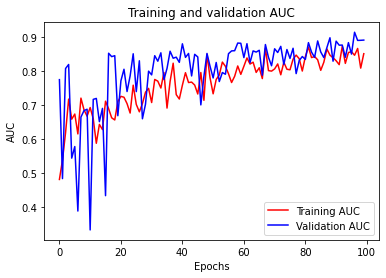

<Figure size 432x288 with 0 Axes>

In [43]:
plot_accuracy_and_loss_train_and_valid(history_simple_cnn_with_augm_and_weights, 'AUC')

The results of the model is very close to one without weighting, so we can say that weighting does not give improvement:

In [44]:
model_simple_cnn_with_augm_and_weights.evaluate(train_generator_with_augm)
model_simple_cnn_with_augm_and_weights.evaluate(validation_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 50s 5s/step - loss: 0.6134 - AUC: 0.8924
  ...
    to  
  ['...']
4/4 [==============================] - 4s 1s/step - loss: 0.4300 - AUC: 0.9150


[0.42999623343348503, 0.915]

### 2.4. Pretrained model (transfer learning)

We have a small dataset in terms of ML, and moreover in terms of deep learning. So learning process can be tough. This is the case where transfer learning could help. The idea is to take ready-to-use model, which was trained on huge amount of data and thus was able to learn more patterns. Then we remove the last layer and replace it with our last layer, and train on our data. 

Here I used example from [coursera course](https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/home/week/3) on CNN with Tensorflow, they have used InceptionV3 model. Let's see how it works with our data. 

In [27]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-03 12:22:15--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  52.9MB/s    in 1.6s    

2020-06-03 12:22:17 (52.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [28]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (input_size, input_size, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 35, 35, 768)


In [29]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer 
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

In [39]:
model_cnn_pretrained_inceptionv3_with_augm = Model( pre_trained_model.input, x) 

model_cnn_pretrained_inceptionv3_with_augm.compile(optimizer = RMSprop(lr = learning_rate), 
              loss = loss_function, 
              metrics = metrics_list)

history_cnn_pretrained_inceptionv3_with_augm = model_cnn_pretrained_inceptionv3_with_augm.fit(train_generator_with_augm,
                              epochs = n_epochs,
                              verbose = 1,
                              validation_data = validation_generator,
                              callbacks = [MyEarlyStopping(monitor = 'val_AUC', 
                                                patience = 25, 
                                                verbose = 1, 
                                                mode = 'max',
                                                min_delta = 0,
                              baseline = 0.9,
                                                restore_best_weights = True)])

model_cnn_pretrained_inceptionv3_with_augm.save('model_cnn_pretrained_inceptionv3_with_augm')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 13s - loss: 0.8127 - AUC: 0.8721
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 182s 17s/step - loss: 0.7511 - AUC: 0.8871 - val_loss: 0.6184 - val_AUC: 0.8587
Epoch 2/100
11/11 [==============================] - 162s 15s/step - loss: 0.2563 - AUC: 0.9700 - val_loss: 0.6850 - val_AUC: 0.8150
Epoch 3/100
10/11 [==========================>...] - ETA: 13s - loss: 0.1493 - AUC: 0.9706
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 170s 15s/step - loss: 0.1530 - AUC: 0.9723 - val_loss: 0.4994 - val_AUC: 0.8859
Epoch 4/100
11/11 [==============================] - 166s 15s/step - loss: 0.2533 - AUC: 0.9591 - val_loss: 0.6125 - val_AUC: 0.8384
Epoch 5/100
11/11 [==============================] - 167s 15s/step - loss: 0.6073 - AUC: 

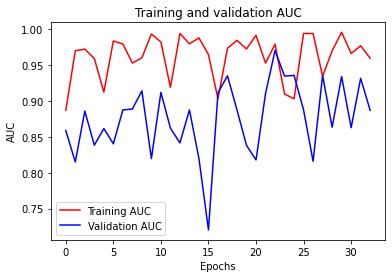

<Figure size 432x288 with 0 Axes>

In [40]:
plot_accuracy_and_loss_train_and_valid(history_cnn_pretrained_inceptionv3_with_augm, 'AUC')

From the chart below we can see that there is an overfitting. But we save weights from the best validation AUC epoch (23rd epoch in this case), this gives similar results for train and validation. And these results are bettern than for simple CNN model:

In [41]:
model_cnn_pretrained_inceptionv3_with_augm.evaluate(train_generator_with_augm)
model_cnn_pretrained_inceptionv3_with_augm.evaluate(validation_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 102s 9s/step - loss: 0.2133 - AUC: 0.9709
  ...
    to  
  ['...']
4/4 [==============================] - 26s 6s/step - loss: 0.2324 - AUC: 0.9703


[0.23238697216766013, 0.9703125]

### 2.5. Simple model with augmentation: add layers

Before choosing final model, let's try to add one more layer and see if this will improve metrics

In [42]:
model_simple_cnn_with_augm_and_more_layers = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(input_size, input_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_simple_cnn_with_augm_and_more_layers.compile(loss = loss_function,
              optimizer = RMSprop(lr = learning_rate),
              metrics = metrics_list)

history_simple_cnn_with_augm_and_more_layers = model_simple_cnn_with_augm_and_more_layers.fit(train_generator_with_augm,
                              epochs = n_epochs,
                              verbose = 1,
                              validation_data = validation_generator,
                            callbacks = [auc_valid_callback])

model_simple_cnn_with_augm_and_more_layers.save('model_simple_cnn_with_augm_and_more_layers')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 4 steps
Epoch 1/100
10/11 [==========================>...] - ETA: 5s - loss: 1.7530 - AUC: 0.4520 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 69s 6s/step - loss: 1.6338 - AUC: 0.4645 - val_loss: 0.3813 - val_AUC: 0.8334
Epoch 2/100
10/11 [==========================>...] - ETA: 5s - loss: 0.5443 - AUC: 0.5687 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 66s 6s/step - loss: 0.5451 - AUC: 0.5491 - val_loss: 0.4217 - val_AUC: 0.8506
Epoch 3/100
11/11 [==============================] - 67s 6s/step - loss: 0.4949 - AUC: 0.6531 - val_loss: 0.4102 - val_AUC: 0.8375
Epoch 4/100
10/11 [==========================>...] - ETA: 5s - loss: 0.6052 - AUC: 0.4868 
Restoring model weights from the end of the best (so far) epoch.
11/11 [==============================] - 67s 6s/step - loss: 0.5968 - AU

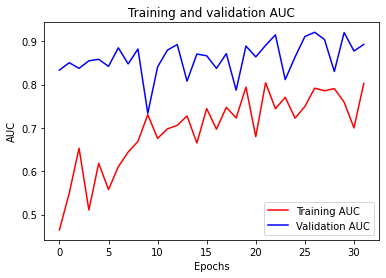

<Figure size 432x288 with 0 Axes>

In [44]:
plot_accuracy_and_loss_train_and_valid(history_simple_cnn_with_augm_and_more_layers, 'AUC')

We can see that there is no much improvement for a model with more layers, and still it is lower than transfer learning results.

In [45]:
model_simple_cnn_with_augm_and_more_layers.evaluate(train_generator_with_augm)
model_simple_cnn_with_augm_and_more_layers.evaluate(validation_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 52s 5s/step - loss: 0.4374 - AUC: 0.8074
  ...
    to  
  ['...']
4/4 [==============================] - 4s 1s/step - loss: 0.3442 - AUC: 0.9209


[0.3441850543022156, 0.9209375]

## 3. Evaluation on test set

So we have seen that InceptionV3 used as transfer learning model, gives better results comparing to simple CNN.

To make the final choice let's evaluate both models on 3 sets - train, validation and test

### 3.1. Calculate AUC on train, validation, test for 2 final models

We can see that indeed InceptionV3 gives better results on all datasets

In [26]:
model_simple_cnn_with_augm = tf.keras.models.load_model('model_simple_cnn_with_augm')

model_simple_cnn_with_augm.evaluate(train_generator_with_augm)
model_simple_cnn_with_augm.evaluate(validation_generator)
model_simple_cnn_with_augm.evaluate(testing_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 50s 5s/step - loss: 0.3290 - AUC: 0.8821
  ...
    to  
  ['...']
4/4 [==============================] - 4s 1s/step - loss: 0.2692 - AUC: 0.9094
  ...
    to  
  ['...']
4/4 [==============================] - 4s 1s/step - loss: 0.2676 - AUC: 0.8841


[0.267625467851758, 0.8840625]

In [27]:
model_cnn_pretrained_inceptionv3_with_augm = tf.keras.models.load_model('model_cnn_pretrained_inceptionv3_with_augm')

model_cnn_pretrained_inceptionv3_with_augm.evaluate(train_generator_with_augm)
model_cnn_pretrained_inceptionv3_with_augm.evaluate(validation_generator)
model_cnn_pretrained_inceptionv3_with_augm.evaluate(testing_generator)

  ...
    to  
  ['...']
11/11 [==============================] - 104s 9s/step - loss: 0.2397 - AUC: 0.9567
  ...
    to  
  ['...']
4/4 [==============================] - 25s 6s/step - loss: 0.2324 - AUC: 0.9703
  ...
    to  
  ['...']
4/4 [==============================] - 25s 6s/step - loss: 0.1139 - AUC: 0.9894


[0.1139135826416009, 0.98937494]

### 3.2. Print confusion matrix based on desirable TPR

Now let's look at confusion matrix, as soon as we are interested in identifying both classes correctly.

In [28]:
test_predictions_num_inceptionv3 = predict_probs(model = model_cnn_pretrained_inceptionv3_with_augm, 
                                                 generator = testing_generator)


AUC: 0.9893749999999999


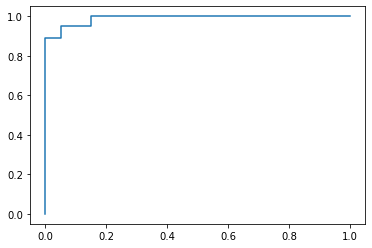

In [30]:
auc_test_inceptionv3, results_df_test_inceptionv3 = calculate_auc_plot_roc(validation_predictions_num = test_predictions_num_inceptionv3, 
                                                                           validation_classes = testing_classes)

We will create confusion matrix based on the threshold so that ensure true positive rate close to 0.95.

We can see that out of 20 Manet's pictures 19 are identified correctly (0.95).

For Monet the result is similar - 75 out of 80 pictures are identified correctly (0.9375).

In [31]:
threshold_test_inceptionv3 = define_threshold_from_tpr(results_df = results_df_test_inceptionv3, 
                                      desired_tpr = 0.95)

calculate_confusion_matrix(validation_predictions_num = test_predictions_num_inceptionv3, 
                           validation_classes = testing_classes, 
                           threshold = threshold_test_inceptionv3)

Threshold: 0.34278956055641174
Confusion matrix: 
[[19  1]
 [ 5 75]]
True positive rate: 0.938
True negative rate: 0.95


### 3.3. Look at misclassified examples

Before we have finished, let's look at misclassified examples to try to spot what could cause a mistake.

For Manet this is one pictures, for Monet - 5. The only idea I have is that 2 of 5 Monet's misclassified pictures are portraits (I guess we can count the dog as a portrait as well :) ), which is more typically for Manet.

False positives (Manet, but classified as Monet):


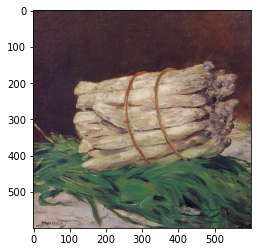

False negative (Monet, but classified as Manet):


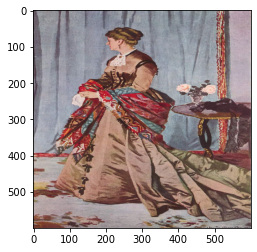

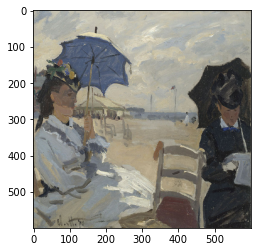

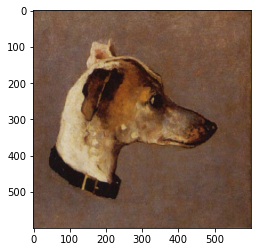

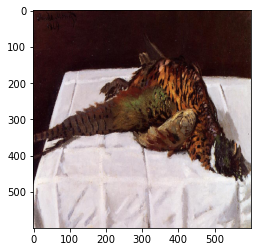

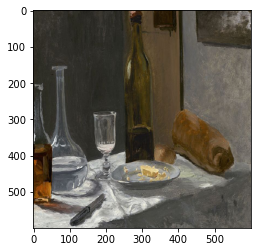

In [32]:
misclassified_test_inceptionv3 = define_misclassified(predictions_num = test_predictions_num_inceptionv3, 
                                                      threshold = threshold_test_inceptionv3, 
                                                      real_class = testing_classes, 
                                                      real_values = testing_values)

print_misclassified(pd_misclassified = misclassified_test_inceptionv3, 
                    n_pics_to_print = 10)